# Calibrando modelos

Al realizar una clasificación, a menudo se desea no sólo predecir la etiqueta de clase, sino también obtener una probabilidad de la etiqueta respectiva. Esta probabilidad le da algún tipo de confianza en la predicción. Algunos modelos pueden ofrecer estimaciones pobres de las probabilidades de clase y otros incluso no admiten la predicción de probabilidades (por ejemplo, algunas instancias de SGDClassifier). El módulo de calibración permite calibrar mejor las probabilidades de un modelo determinado o añadir soporte para la predicción probabilística.

Los clasificadores bien calibrados son clasificadores probabilísticos para los que la salida del método `predict_proba` puede interpretarse directamente como un nivel de confianza. Por ejemplo, un clasificador (binario) bien calibrado debería clasificar las muestras de tal forma que entre las muestras a las que dio un valor predict_proba cercano a, digamos, 0.8, aproximadamente el 80% pertenecen realmente a la clase positiva.

Antes de mostrar cómo recalibrar un clasificador, primero necesitamos una forma de detectar lo bien calibrado que está un clasificador.

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = SVC(probability=True)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

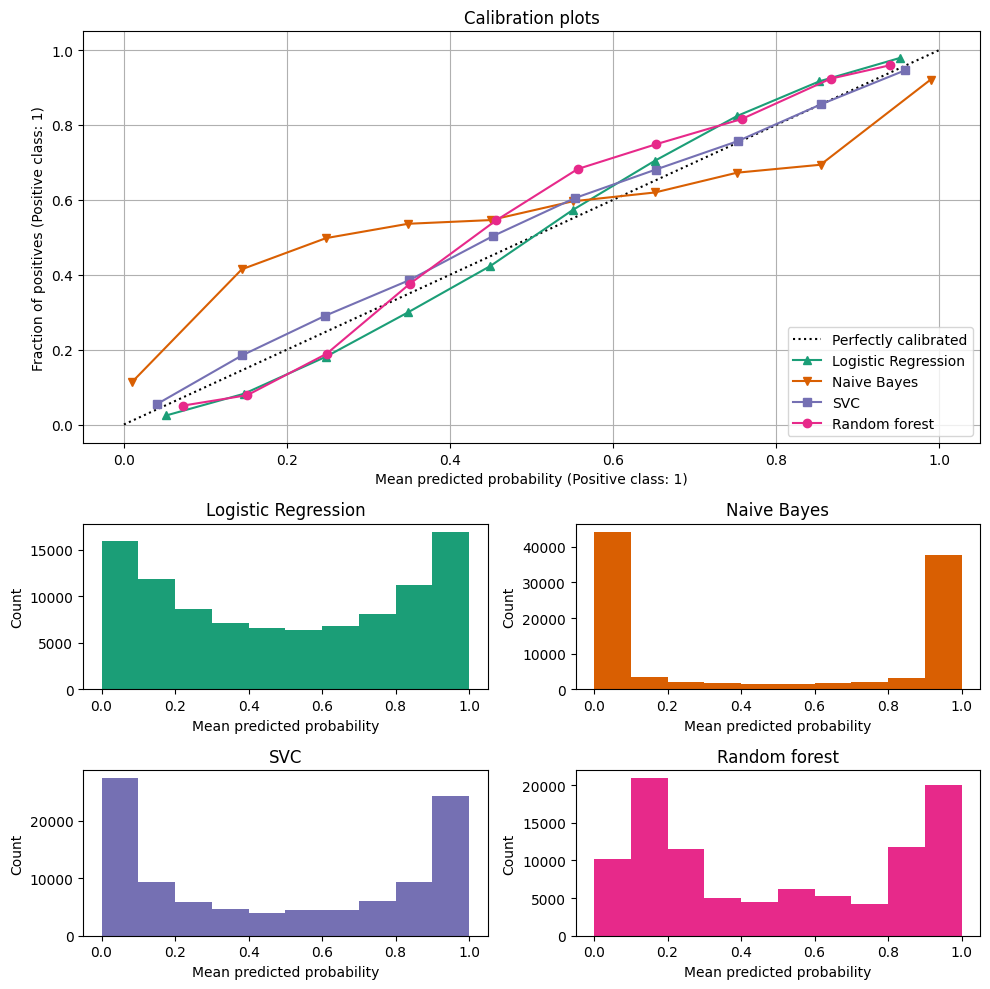

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### Brier score

Aunque las curvas de calibración aportan información detallada, es interesante disponer de una métrica que permita cuantificar con un único valor la calidad de calibración del modelo. La puntuación de Brier es la diferencia cuadrática media (mean squared difference) entre la probabilidad estimada por el modelo y la probabilidad real (1 para la clase positiva y 0 para la negativa).

$$

BS = \frac{1}{N} \sum_{t=1}^N (f_t - o_t)^2

$$
donde $f_t$ es la probabilidad asociada a la predicción, $o_t$ es la salida real del evento para la instancia $t$ y $N$ es el número de predicciones.

Supongamos que se está pronosticando la probabilidad $P$ de que llueva un día determinado. Entonces, la puntuación Brier se calcula de la siguiente manera:

* Si el pronóstico es del 100% ($P = 1$) y llueve, entonces la puntuación Brier es 0, la mejor puntuación alcanzable.
* Si la previsión es del 100% y no llueve, la puntuación Brier es 1, la peor puntuación posible.
* Si la previsión es del 70% ($P = 0.7$) y llueve, entonces la puntuación Brier es $(0.7-1)^2 = 0.09$.
* Por el contrario, si la previsión es del 70% ($P = 0.7$) y no llueve, entonces la puntuación Brier es $(0.7-0)^2 = 0.49$.
* Si el pronóstico es del 50% ($P = 0.5$), entonces la puntuación Brier es 0.25, independientemente de si llueve.

Cuanto menor es su valor, mejor calibrado está el modelo. Esta métrica es adecuada solo para clasificaciones binarias. [Wikipedia](https://en.wikipedia.org/wiki/Brier_score)

In [7]:
from sklearn.metrics import classification_report, brier_score_loss

brier_score = brier_score_loss(y_test, gnb.predict_proba(X = X_test)[:, 1])
print(f"Brier score = {brier_score}")
print("")
print(classification_report(y_test, gnb.predict(X = X_test)))

Brier score = 0.12441245425319994

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     49943
           1       0.87      0.81      0.84     49957

    accuracy                           0.85     99900
   macro avg       0.85      0.85      0.84     99900
weighted avg       0.85      0.85      0.84     99900



## Calibrado

Calibrar un clasificador consiste en ajustar un regresor (llamado calibrador) que asigna la salida del clasificador (dada por la función de decisión o función `predecir_proba`) a una probabilidad calibrada en $[0, 1]$. Denotando la salida del clasificador para una muestra dada $f_i$ el calibrador intenta predecir la probabilidad condicional del suceso $P(y_i = 1 |f_i)$.

Idealmente, el calibrador se ajusta en un conjunto de datos independiente de los datos de entrenamiento utilizados para ajustar el clasificador en primer lugar. Esto se debe a que el rendimiento del clasificador en sus datos de entrenamiento sería mejor que para los datos nuevos. Utilizar la salida del clasificador de los datos de entrenamiento para ajustar el calibrador daría como resultado un calibrador sesgado que asigna probabilidades más cercanas a 0 y 1 de lo que debería.

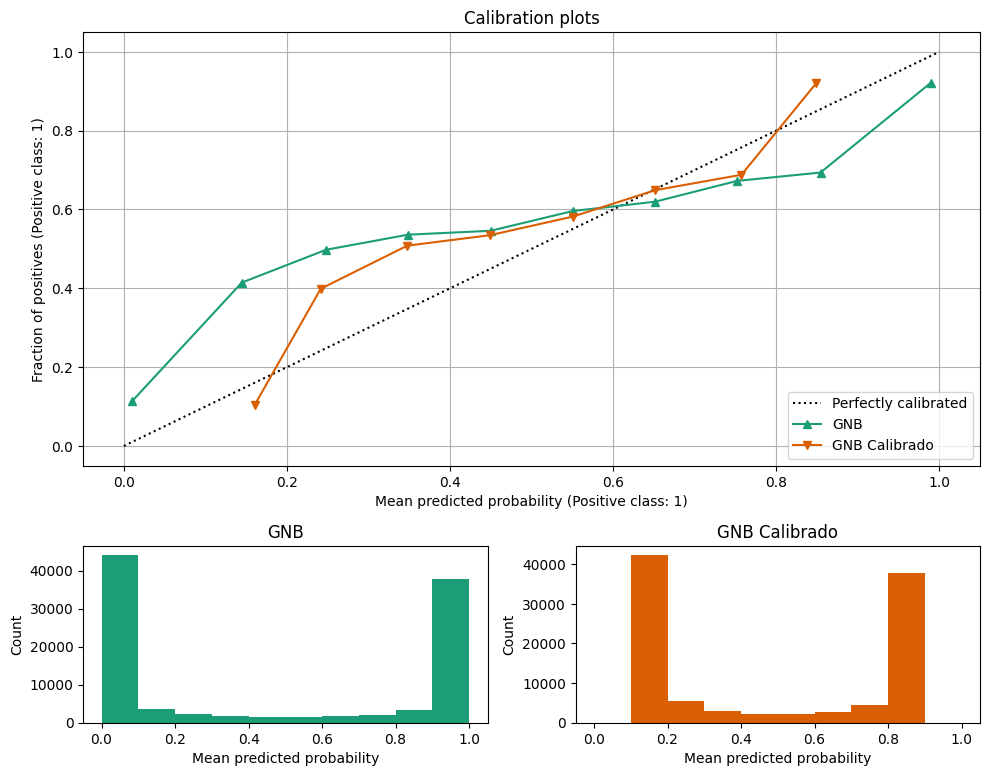

In [9]:
from sklearn.calibration import CalibratedClassifierCV

base_clf = GaussianNB()
calibrated = CalibratedClassifierCV(GaussianNB(), cv=5)

clf_list = [
    (gnb, "GNB"),
    (calibrated, "GNB Calibrado"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [10]:
brier_score = brier_score_loss(y_test, calibrated.predict_proba(X = X_test)[:, 1])

print(f"Brier score = {brier_score}")
print("")
print(classification_report(y_test, calibrated.predict(X = X_test)))

Brier score = 0.11826167740853877

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     49943
           1       0.87      0.82      0.84     49957

    accuracy                           0.85     99900
   macro avg       0.85      0.85      0.85     99900
weighted avg       0.85      0.85      0.85     99900



## Referencias

* https://scikit-learn.org/stable/modules/calibration.html
* https://cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning.html